# Student Performance Microbenchmark
Simple statistical queries about students in a Portuguese class.
This file is adapted to use numpy only without Spark.

In [2]:
EXPERIMENT = 'pac-student_performance-sparkless'
OUTPUT_DIR = f'./outputs/{EXPERIMENT}'
GENERATE = True

if GENERATE:
    print("GENERATE = True, so we will generate new samples.")
else:
    print("GENERATE = False, so we will load saved output from files rather than recomputing.")

import os
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

GENERATE = True, so we will generate new samples.


### Running PAC

In [3]:
from typing import Any, Callable, Dict, List, Tuple, Union

import numpy as np
import pandas as pd
from pandas import DataFrame
import concurrent.futures
import pyarrow as pa
import pyarrow.parquet as pq
import pickle
from numpy.random import laplace
from functools import reduce
import operator

In [4]:
### Mayuri's conversion functions between DP epsilon and PAC MI using posterior advantage for equivalence
def calc_posterior(mi, prior=0.5, prec = 100000):
    test_vals = [x / prec for x in range(1, prec)]
    max_t = None
    for t in test_vals:
        if t*np.log(t/prior)+(1-t)*np.log((1-t)/(1-prior)) <= mi:
            if  max_t is None or t > max_t:
                max_t = t
    return max_t

def dp_epsilon_to_posterior_success(epsilon):
    return 1 - 1./(1+np.exp(epsilon))

def dp_ps_to_epsilon(ps):
    return np.log(ps / (1-ps))

# example usage:
# dp_ps_to_epsilon(calc_posterior(1/256.))

In [5]:
### Data Setup
por_df = pq.read_table(f"./data/student_performance/student-por.parquet").to_pandas()
por_df.shape

(649, 33)

In [6]:
por_df['absences'].count()

649

In [7]:
por_df['absences'].agg(['count', 'mean']).to_numpy()

array([649.        ,   3.65947612])

In [29]:
### Query Setup
SAMPLES = 512
assert SAMPLES % 2 == 0, "We need an even number of samples for paired sampling."
number_of_pairs = SAMPLES // 2

true_result = por_df['absences'].agg(['count', 'mean']).to_numpy() # Save the true result of the query for later
number_of_contributing_rows = por_df['absences'].count()

def rowwise_paired_sample(df: DataFrame) -> Tuple[DataFrame, DataFrame]:
    """
    This will select half of the row indices from the dataframe at random.
    The first result is the dataframe composed of the selected rows.
    The second result is the complement / the dataframe composed of the rows that were not selected.
    """
    indices = np.random.choice(df.index, size=(df.shape[0] // 2), replace=False)
    not_indices = list(set(df.index) - set(indices))
    selected: DataFrame = df.iloc[indices]
    not_selected: DataFrame = df.iloc[not_indices]
    return (selected, not_selected)

def run_query(i: int) -> List[np.ndarray]:
    # i is not used for anything, just to satisfy the map function.
    # Returns two results each invocation as a result of paired sampling.
    results = []
    for temp_df in rowwise_paired_sample(por_df):
        out_df = temp_df['absences'].agg(['count', 'mean'])  # run the query
        #out_df['count'] *= 2  # correct query result for the 50% subsampling
        #out_df['sum'] *= 2  # correct query result for the 50% subsampling
        results.append(out_df.to_numpy())
    return results

def generate_samples(laplace_lambda: float = 1.0, alpha: int = 10) -> List[np.ndarray]:
    # thresholding happens here for PAC -- if there are less than alpha samples
    # (with some Laplacian noise), then we don't subsample and return None.
    laplace_noise: float = np.random.laplace(scale=laplace_lambda)
    if number_of_contributing_rows + laplace_noise < alpha:  # if we don't get enough results from the query
        print("There are not enough rows contributing to the result for PAC to be meaningful.")
        return []
    
    out_np: List[np.ndarray] = []
    for i in range(number_of_pairs):
        out_np.append(run_query(i))
    out_np = reduce(operator.iconcat, out_np, [])
    # https://stackoverflow.com/a/45323085

    #with concurrent.futures.ThreadPoolExecutor() as executor:
    #    out_np: List[np.ndarray] = list(executor.map(run_query, range(number_of_pairs)))
    #    out_np = reduce(operator.iconcat, out_np, [])
    #    # https://stackoverflow.com/a/45323085

    return out_np

In [9]:
s = generate_samples()
s

[array([324.        ,   3.75617284]),
 array([325.        ,   3.56307692]),
 array([324.       ,   3.7808642]),
 array([325.        ,   3.53846154]),
 array([324.        ,   3.49382716]),
 array([325.        ,   3.82461538]),
 array([324.        ,   3.71296296]),
 array([325.        ,   3.60615385]),
 array([324.        ,   3.53703704]),
 array([325.        ,   3.78153846]),
 array([324.       ,   3.7345679]),
 array([325.        ,   3.58461538]),
 array([324.        ,   3.67901235]),
 array([325.  ,   3.64]),
 array([324.        ,   3.49074074]),
 array([325.        ,   3.82769231]),
 array([324.        ,   3.66049383]),
 array([325.        ,   3.65846154]),
 array([324.       ,   3.5154321]),
 array([325.        ,   3.80307692]),
 array([324.        ,   3.74382716]),
 array([325.        ,   3.57538462]),
 array([324.        ,   3.71296296]),
 array([325.        ,   3.60615385]),
 array([324.        ,   3.62654321]),
 array([325.        ,   3.69230769]),
 array([324.        ,   3.8611

In [11]:
# plot s[1] for all in list
#pd.DataFrame(s, columns=['count', 'mean']).hist("sum")

In [13]:
#pd.DataFrame(s, columns=['count', 'mean'])['sum']

In [62]:
# compute variance of pd.DataFrame(s, columns=['count', 'mean'])['sum']
np.var(pd.DataFrame(s, columns=['count', 'mean'])['sum'])

3442.03125

In [18]:
### Compute PAC Noise
def updateDataFrame(vec: np.ndarray, df: DataFrame) -> DataFrame:
    """
    Update a DataFrame with a noisy output vector.
    """
    noisy_output_df = df.copy()
    noisy_output_df.loc[0] = vec
    return noisy_output_df

saved_pac_variables = []
# (out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release)

def do_pac_and_release(out_np: List[np.ndarray],
                       max_mi: float = 1./4) -> np.ndarray:

    
    dimensions: int = len(out_np[0])

    out_np_2darr = [np.atleast_2d(o) for o in out_np] # make sure all the DF -> np.ndarray conversions result in 2d arrays

    est_y: np.ndarray = np.stack(out_np_2darr, axis=-1).reshape(dimensions, SAMPLES)

    # get the variance in each basis direction
    fin_var: np.ndarray = np.var(est_y, axis=1)  # shape (dimensions,)
    sqrt_total_var: np.floating[Any] = np.sum(np.sqrt(fin_var))

    pac_noise: np.ndarray = (1./(2*max_mi)) * sqrt_total_var * np.sqrt(fin_var)  # variance of the PAC noise
    pac_noises_to_add: np.ndarray = np.random.normal(loc=0, scale=pac_noise)
    # Add noise element-wise to the outputs
    pac_release = out_np[0] + pac_noises_to_add

    saved_pac_variables.append((out_np[0], fin_var, sqrt_total_var, pac_noise, pac_noises_to_add, pac_release))
    
    return pac_release

# Update the DataFrame with the noisy output
# noisy_output_df = updateDataFrame(pac_release, out[0])

In [35]:
saved_pac_variables_df['fin_var'].head()

0    [0.25, 0.055750358774595096]
1     [0.25, 0.01659167928146538]
2     [0.25, 0.04180413030410051]
3     [0.25, 0.03340589099069009]
4    [0.25, 0.041432262434498976]
Name: fin_var, dtype: object

In [36]:
saved_pac_variables_df['out_np_0'].head()

0     [324.0, 3.484567901234568]
1    [324.0, 3.4814814814814814]
2    [324.0, 3.8950617283950617]
3     [324.0, 3.632716049382716]
4    [324.0, 3.8395061728395063]
Name: out_np_0, dtype: object

In [37]:
true_result

array([649.        ,   3.65947612])

To replicate the experiment that runs for epsilon=0.01, 0.1, 1, 10
we use mi=1, 1/4, 1/16, 1/64, 1/256 in the hopes of encompassing a similar range.

In [30]:
MI_OPTIONS = [16., 4., 2., 1., 1/4, 1/16, 1/32, 1/64]
EXPERIMENTS = 100

if GENERATE:
    # df = pd.DataFrame([], columns=['mi', 'count', 'sum', 'mean', 'var'])
    experiment_results = []

    for mi in MI_OPTIONS: 
        for e in range(EXPERIMENTS):
            out_np = generate_samples()
            noisy_output = do_pac_and_release(out_np, mi)
            # try x2 here ?
            experiment_results.append([mi, *noisy_output])
        with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
            pickle.dump(experiment_results, f)
    
    df = pd.DataFrame(experiment_results, columns=['mi', 'count', 'mean'])
    
    # Save the new data to outputs/...
    df.to_parquet(f'{OUTPUT_DIR}/pac_results.parquet')
    # with open(f'{OUTPUT_DIR}/experiment_results.pkl', 'wb') as f:
    #     pickle.dump(experiment_results, f)
else:
    df = pq.read_table(f"{OUTPUT_DIR}/pac_results.parquet").to_pandas()

    # with open('{OUTPUT_DIR}/experiment_results.pkl', 'rb') as f:
    #     experiment_results = pickle.load(f)

df.head()

,mi,count,mean
0,16.0,324.009832,3.668017
1,16.0,323.992821,3.698458
2,16.0,323.998213,3.672040
3,16.0,324.015733,3.905108
4,16.0,324.006543,3.747940


In [38]:
if GENERATE:
    saved_pac_variables_df = pd.DataFrame(saved_pac_variables, columns=['out_np_0', 'fin_var', 'sqrt_total_var', 'pac_noise', 'pac_noises_to_add', 'pac_release'])
    saved_pac_variables_df.to_parquet(f'{OUTPUT_DIR}/saved_pac_variables.parquet')
    saved_pac_variables_df.head()
else:
    saved_pac_variables_df = pq.read_table(f"{OUTPUT_DIR}/saved_pac_variables.parquet").to_pandas()
    saved_pac_variables_df.head()

### Computing PAC Errors

In [39]:
# functions to calculate errors
def absolute_scaled_error(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return np.abs(est - actual)
def relative_error_percent(est: np.ndarray, actual: np.ndarray) -> np.ndarray:
    return (np.abs(est - actual) / actual) * 100

In [54]:
df

,mi,count,mean
0,16.000000,324.009832,3.668017
1,16.000000,323.992821,3.698458
2,16.000000,323.998213,3.672040
3,16.000000,324.015733,3.905108
4,16.000000,324.006543,3.747940
...,...,...,...
795,0.015625,317.807040,-0.048489
796,0.015625,327.331287,4.732904
797,0.015625,318.780239,3.931177
798,0.015625,340.065756,5.221764


In [55]:
# compute errors for PAC (or import from saved file)
if GENERATE:
    errors_list = []
    for i, row in df.iterrows():
        mi = row['mi']
        r = row[['count', 'mean']].to_numpy()
        r[0] *= 2 # todo gross
        errors_list.append([mi, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    pac_errors_df = pd.DataFrame(errors_list, columns=['mi', 'absolute error count',  'absolute error mean',  'relative error count',  'relative error mean'])
    pac_errors_df.to_parquet(f"{OUTPUT_DIR}/pac_errors.parquet")  # overwrite saved
else:
    pac_errors_df = pq.read_table(f"{OUTPUT_DIR}/pac_errors.parquet").to_pandas()
pac_errors_df

,mi,absolute error count,absolute error mean,relative error count,relative error mean
0,16.000000,0.980335,0.008541,0.151053,0.233393
1,16.000000,1.014358,0.038981,0.156295,1.065220
2,16.000000,1.003574,0.012564,0.154634,0.343331
3,16.000000,0.968534,0.245632,0.149235,6.712216
4,16.000000,0.986913,0.088464,0.152067,2.417396
...,...,...,...,...,...
795,0.015625,13.385919,3.707965,2.062545,101.325014
796,0.015625,5.662574,1.073428,0.872508,29.332842
797,0.015625,11.439522,0.271701,1.762638,7.424579
798,0.015625,31.131513,1.562288,4.796843,42.691576


In [41]:
# if GENERATE:
#     mean_df = df.groupby('mi').mean()[['count', 'sum', 'mean', 'var']]
#     std_df = df.groupby('mi').std()[['count', 'sum', 'mean', 'var']].abs()
#     mean_df, std_df

#     # save mean_df, std_df to parquet
#     mean_df.to_parquet('{OUTPUT_DIR}/pac-mean_df_student-por.parquet')
#     std_df.to_parquet('{OUTPUT_DIR}/pac-std_df_student-por.parquet')

### Analysis of PAC vs DP
- import the DP data
- create a dataframe (`all_df`) containing the query outputs
    - in this df, each output is the {mean, variance} aggregation over the 500 experiments, grouped by the type of privacy mechanism used (pac or dp) and privacy factor (mi or epsilon)
- create a dataframe in the same pattern containing the computed error for each privitized output

In [56]:
# Import Chai's saved data from running PipelineDP and use it to compare.
dp_results_df = pq.read_table(f"outputs/dp_results.parquet").to_pandas()

In [57]:
# compute errors for PAC (or import from saved file)
GENERATE_DP = True
if GENERATE_DP:
    errors_list = []
    for i, row in dp_results_df.iterrows():
        eps = row['eps']
        r = row[['count', 'mean']].to_numpy()
        errors_list.append([eps, *absolute_scaled_error(r, true_result), *relative_error_percent(r, true_result)])
    dp_errors_df = pd.DataFrame(errors_list, columns=['eps', 'absolute error count', 'absolute error mean',  'relative error count', 'relative error mean'])
    dp_errors_df.to_parquet(f"outputs/dp_errors.parquet")  # overwrite saved
else:
    dp_errors_df = pq.read_table(f"outputs/dp_errors.parquet").to_pandas()
dp_errors_df

,eps,absolute error count,absolute error mean,relative error count,relative error mean
0,0.177101,NaN,NaN,NaN,NaN
1,0.250949,NaN,NaN,NaN,NaN
2,0.356323,NaN,NaN,NaN,NaN
3,0.730432,NaN,NaN,NaN,NaN
4,1.642612,629.698176,2.496137,97.025913,68.210218
...,...,...,...,...,...
4495,1.642612,622.863204,NaN,95.972759,NaN
4496,11.512915,624.868812,2.085817,96.281789,56.997697
4497,11.512915,625.599796,2.840868,96.394422,77.630467
4498,11.512915,624.166563,2.733568,96.173585,74.698332


In [58]:
### Make one merged DF to compare results
all_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_results_df.assign(type='dp').rename(columns={'eps': 'factor'}),
    df.assign(type='pac').rename(columns={'mi': 'factor'})
])
all_df = all_df.groupby(['type', 'factor']).agg(['mean', 'var'])
all_df.columns = [' '.join(col).strip() for col in all_df.columns.values]  # Flatten the columns
all_df.to_parquet(f"{OUTPUT_DIR}/all_results.parquet")
all_df

count mean   count var     sum mean       sum var  mean mean  \
type factor                                                                    
dp   0.177101          NaN         NaN          NaN           NaN        NaN   
     0.250949          NaN         NaN          NaN           NaN        NaN   
     0.356323          NaN         NaN          NaN           NaN        NaN   
     0.730432    17.881807  271.792103 -9499.419295  3.721044e+08        NaN   
     1.642612    24.454480   26.719645   155.046107  2.572769e+08   0.085301   
     11.512915   23.998055    0.764664    27.330774  7.073547e+06   0.983378   
pac  0.015625   324.651184  109.803696          NaN           NaN   3.468054   
     0.031250   323.504754   32.406502          NaN           NaN   3.676361   
     0.062500   324.034817    8.059322          NaN           NaN   3.620110   
     0.250000   324.078780    0.555321          NaN           NaN   3.718551   
     1.000000   323.989264    0.036254          NaN           NaN   3.665489   
     2.000000   323.999394    0.007106          NaN           NaN   3.658465   
     4.000000   323.992852    0.002202          NaN           NaN   3.648376   
     16.000000  323.998853    0.000108          NaN           NaN   3.654647   

                 mean var       var mean       var var  
type factor                                             
dp   0.177101         NaN            NaN           NaN  
     0.250949         NaN            NaN           NaN  
     0.356323         NaN  -16385.315380           NaN  
     0.730432         NaN -139294.774296  5.917808e+10  
     1.642612    9.914569 -225881.492690  1.054887e+12  
     11.512915   0.125159     -74.651985  6.781333e+05  
pac  0.015625   15.326304            NaN           NaN  
     0.031250    3.980801            NaN           NaN  
     0.062500    1.152128            NaN           NaN  
     0.250000    0.104497            NaN           NaN  
     1.000000    0.034520            NaN           NaN  
     2.000000    0.030987            NaN           NaN  
     4.000000    0.042839            NaN           NaN  
     16.000000   0.029977            NaN           NaN

In [59]:
### Make another merged df for the errors
errors_df = pd.concat([  # we will call mi and epsilon the "factor" so that the schemas match
    dp_errors_df.assign(type='dp').rename(columns={'eps': 'factor'}), 
    pac_errors_df.assign(type='pac').rename(columns={'mi': 'factor'})
])
errors_df = errors_df.groupby(['type', 'factor']).agg(['mean', 'var'])
# drop absolute * mean and relative * var columns from level 1
errors_df = errors_df.drop(columns=[('absolute error count', 'mean'), ('absolute error mean', 'mean'), ('relative error count', 'var'), ('relative error mean', 'var')])
errors_df.columns = [' '.join(col).strip() for col in errors_df.columns.values]  # flatten the columns

errors_df.to_parquet(f"{OUTPUT_DIR}/all_errors.parquet")
errors_df

absolute error count var  absolute error mean var  \
type factor                                                         
dp   0.177101                        NaN                      NaN   
     0.250949                        NaN                      NaN   
     0.356323                        NaN                      NaN   
     0.730432                 271.792103                      NaN   
     1.642612                  26.719645                 9.680968   
     11.512915                  0.764664                 0.125159   
pac  0.015625                 155.941020                 6.201600   
     0.031250                  44.337470                 1.216447   
     0.062500                  11.458291                 0.437072   
     0.250000                   1.055997                 0.034385   
     1.000000                   0.145017                 0.011025   
     2.000000                   0.028426                 0.008771   
     4.000000                   0.008807                 0.014769   
     16.000000                  0.000433                 0.012183   

                relative error count mean  relative error mean mean  
type factor                                                          
dp   0.177101                         NaN                       NaN  
     0.250949                         NaN                       NaN  
     0.356323                         NaN                       NaN  
     0.730432                   97.244714                       NaN  
     1.642612                   96.231975                 98.550360  
     11.512915                  96.302303                 73.127906  
pac  0.015625                    2.580755                 82.297588  
     0.031250                    1.448691                 45.208290  
     0.062500                    0.713403                 23.016727  
     0.250000                    0.210330                  7.378139  
     1.000000                    0.157392                  4.170908  
     2.000000                    0.154270                  4.052684  
     4.000000                    0.156286                  4.565452  
     16.000000                   0.154437                  3.629379

In [60]:
#abs_error = errors_df.groupby('mi').mean()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

#std_abs_error = errors_df.groupby('mi').std()[['absolute error count', 'absolute error sum', 'absolute error mean', 'absolute error var']]
#sample_mean_rel_error = errors_df.groupby('mi').mean()[['relative error count', 'relative error sum', 'relative error mean', 'relative error var']]

# save std_abs_error, sample_mean_rel_error to parquet
# std_abs_error.to_parquet('outputs/pac-std_abs_error_student-por.parquet')
# sample_mean_rel_error.to_parquet('outputs/pac-sample_mean_rel_error_student-por.parquet')

### Plotting Results

We are reproducing Table 14 from this paper: http://arxiv.org/abs/2109.10789

> TABLE 14: Experiments of the queries count, sum, mean, and var on the attribute Absences of the Portuguese education dataset containing 649 individuals (500 experiments per ε).

In [61]:
### Imports for matplotlib
import matplotlib as mpl
#import seaborn as sns
import matplotlib.pyplot as plt
#sns.reset_orig()

# Michael's matplotlib defaults
# set font to Times New Roman
LATEX = False
if LATEX:
    mpl.rcParams['text.usetex'] = True
    mpl.rcParams["font.family"] = "serif"
    mpl.rcParams["font.serif"] = "Times"
else:
    mpl.rcParams['text.usetex'] = False
    mpl.rcParams["font.family"] = "Times New Roman"
    mpl.rcParams["mathtext.fontset"] = "stix"
    
plt.rcParams['svg.fonttype'] = 'none'
mpl.rcParams['savefig.dpi'] = 300

import matplotlib_inline.backend_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg')

mpl.rcParams['axes.titleweight'] = 'bold'

In [62]:
PAC_COLOR = 'tab:blue'
DP_COLOR = 'tab:red'

# create legend, use color squares
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
pac_dp_legend_handles = [
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP')
]

Reproduction of Table 14 (PAC)

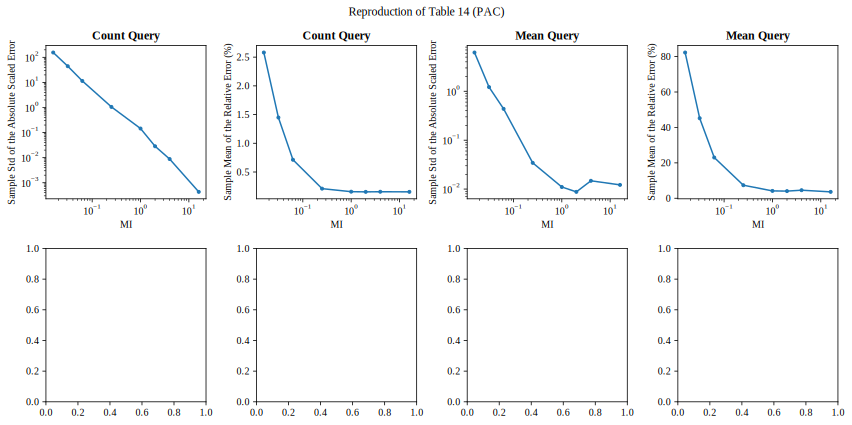

In [63]:
### Reproduction of Table 14 (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'mean']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac.jpg", bbox_inches='tight')
plt.show()

Reproduction of Table 14 (DP)

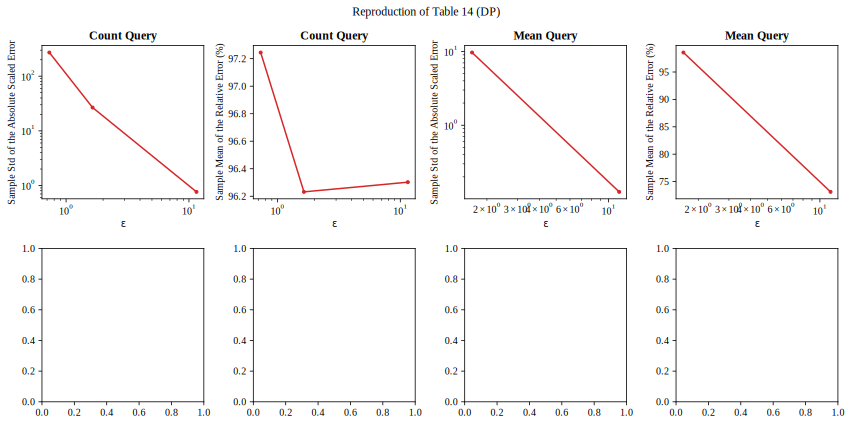

In [64]:
### Reproduction of Table 14 (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'mean']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'
    d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
             #label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc[TYPE].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')

fig.suptitle("Reproduction of Table 14 (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_dp.jpg", bbox_inches='tight')
plt.show()

An attempt at putting both on the same axes, not aligned

In [77]:
errors_df

absolute error count var  absolute error mean var  \
type factor                                                         
dp   0.177101                        NaN                      NaN   
     0.250949                        NaN                      NaN   
     0.356323                        NaN                      NaN   
     0.730432                 271.792103                      NaN   
     1.642612                  26.719645                 9.680968   
     11.512915                  0.764664                 0.125159   
pac  0.015625                 155.941020                 6.201600   
     0.031250                  44.337470                 1.216447   
     0.062500                  11.458291                 0.437072   
     0.250000                   1.055997                 0.034385   
     1.000000                   0.145017                 0.011025   
     2.000000                   0.028426                 0.008771   
     4.000000                   0.008807                 0.014769   
     16.000000                  0.000433                 0.012183   

                relative error count mean  relative error mean mean  
type factor                                                          
dp   0.177101                         NaN                       NaN  
     0.250949                         NaN                       NaN  
     0.356323                         NaN                       NaN  
     0.730432                   97.244714                       NaN  
     1.642612                   96.231975                 98.550360  
     11.512915                  96.302303                 73.127906  
pac  0.015625                    2.580755                 82.297588  
     0.031250                    1.448691                 45.208290  
     0.062500                    0.713403                 23.016727  
     0.250000                    0.210330                  7.378139  
     1.000000                    0.157392                  4.170908  
     2.000000                    0.154270                  4.052684  
     4.000000                    0.156286                  4.565452  
     16.000000                   0.154437                  3.629379

factor
0.015625     2.580755
0.031250     1.448691
0.062500     0.713403
0.250000     0.210330
1.000000     0.157392
2.000000     0.154270
4.000000     0.156286
16.000000    0.154437
Name: relative error count mean, dtype: float64
factor
0.015625     82.297588
0.031250     45.208290
0.062500     23.016727
0.250000      7.378139
1.000000      4.170908
2.000000      4.052684
4.000000      4.565452
16.000000     3.629379
Name: relative error mean mean, dtype: float64


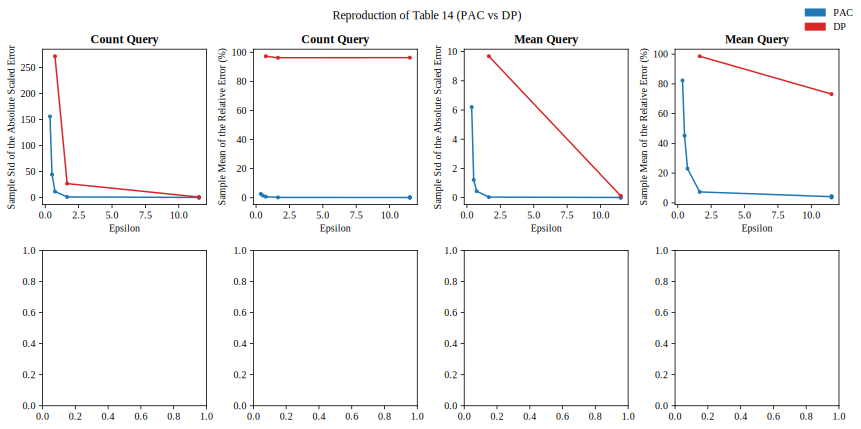

In [ ]:
### An attempt at putting errors of both on the same axes, not aligned
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count','mean']

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Sample Std of Absolute Scaled Error
    d = errors_df.loc['pac'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index.map(lambda x: dp_ps_to_epsilon(calc_posterior(x))), d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'absolute error {query} var']
    ax1.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_ylabel('Sample Std of the Absolute Scaled Error')
    ax1.set_xlabel('Epsilon')

    # Plotting Sample Mean of the Relative Error (%)
    d = errors_df.loc['pac'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index.map(lambda x: dp_ps_to_epsilon(calc_posterior(x))), d, label=query, marker='.', color=PAC_COLOR)

    d = errors_df.loc['dp'].loc[:, f'relative error {query} mean']
    ax2.plot(d.index, d, label=query, marker='.', color=DP_COLOR)

    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_ylabel('Sample Mean of the Relative Error (%)')
    ax2.set_xlabel('Epsilon')

    #ax2b = ax2.twiny()

    #ax2.set_xscale('log')
 

    # align the scales
    # get range of x-axis for PAC
    #ax1min, ax1max = ax1.get_xlim()
    #ax1mineps, ax1maxeps = dp_ps_to_epsilon(calc_posterior(ax1min)), dp_ps_to_epsilon(calc_posterior(ax1max))
   # ax1b.set_xlim(ax1mineps, ax1maxeps)

   # ax2min, ax2max = ax2.get_xlim()
   # ax2mineps, ax2maxeps = dp_ps_to_epsilon(calc_posterior(ax2min)), dp_ps_to_epsilon(calc_posterior(ax2max))
   # ax2b.set_xlim(ax2mineps, ax2maxeps)



fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False)

fig.suptitle("Reproduction of Table 14 (PAC vs DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/table14_pac_vs_dp.jpg", bbox_inches='tight')
plt.show()

In [ ]:
# with 'relative error count' / 2
pac_errors_df.pivot_table(index='mi', aggfunc='mean').with_column('relative error count', 'relative error count' / 2)

### Plotting the error for comparison

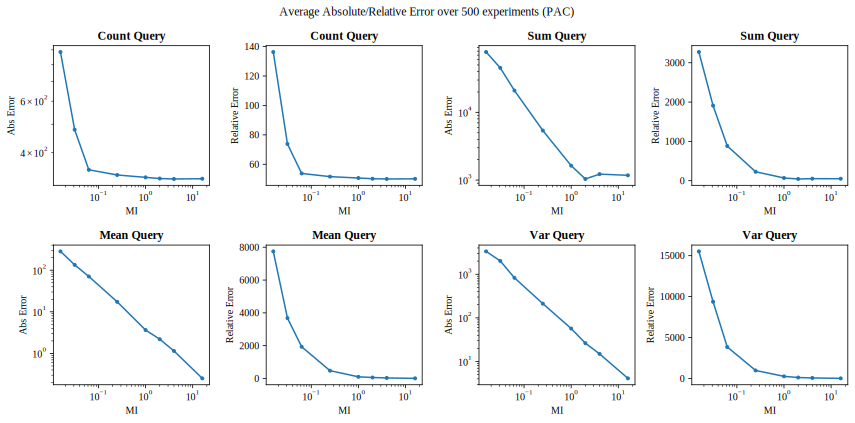

In [39]:
### Average Absolute/Relative error over 500 experiments (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = pac_errors_df.pivot_table(index='mi', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('MI')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('MI')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (PAC)")
plt.tight_layout()
plt.show()

In [25]:
true_result

array([ 649.        , 2375.        ,    3.65947612,   21.53664232])

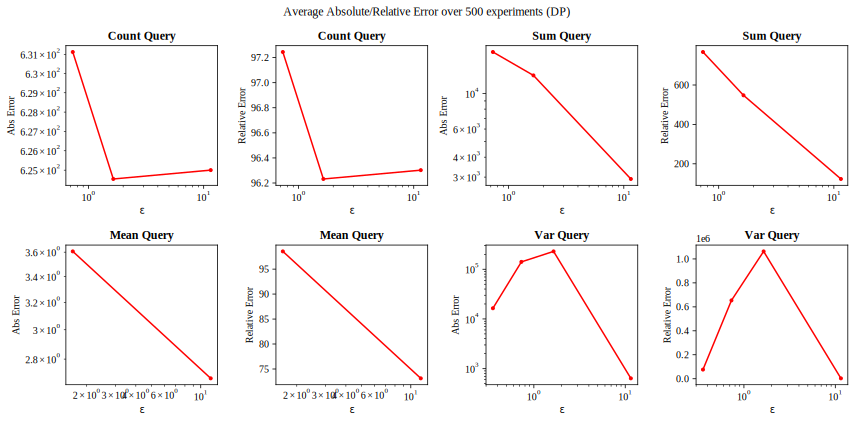

In [26]:
### Average Absolute/Relative error over 500 experiments (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 4, figsize=(12, 6))
queries = ['count', 'sum', 'mean', 'var']

to_plot = dp_errors_df.pivot_table(index='eps', aggfunc='mean')  # create temporary df with aggregation to plot

# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = (i*2)//4
    col = (i*2) % 4
    ax1 = axs[row][col]
    ax2 = axs[row][col+1]

    # Plotting Absolute Scaled Error
    ax1.plot(to_plot.index, to_plot[f'absolute error {query}'], label=query, marker='.', color='red')
    ax1.set_xscale('log')
    ax1.set_yscale('log')
    ax1.set_title(f'{query.capitalize()} Query')
    ax1.set_xlabel('$\epsilon$')
    ax1.set_ylabel('Abs Error')

    # Plotting Relative Error (%)
    ax2.plot(to_plot.index, to_plot[f'relative error {query}'], label=query, marker='.', color='red')
    ax2.set_xscale('log')
    ax2.set_title(f'{query.capitalize()} Query')
    ax2.set_xlabel('$\epsilon$')
    ax2.set_ylabel('Relative Error')
    
del to_plot  # delete the temporary DataFrame

fig.suptitle("Average Absolute/Relative Error over 500 experiments (DP)")
plt.tight_layout()
plt.show()

In [27]:
# Used to convert dp.csv to dp-results.parquet; no longer needed
if False:
    with open('dp.csv', 'r') as f:
        dp_results = pd.read_csv(f)
    # rename headings
    mapping = {
        "Epsilon": "epsilon",
        "Average Absolute Error over 500 Samples - Count": "absolute error count",
        "Average Relative Error over 500 Samples - Count": "relative error count",
        "Average Absolute Error over 500 Samples - Sum": "absolute error sum",
        "Average Relative Error over 500 Samples - Sum": "relative error sum",
        "Average Absolute Error over 500 Samples - Mean": "absolute error mean",
        "Average Relative Error over 500 Samples - Mean": "relative error mean",
        "Average Absolute Error over 500 Samples - Var": "absolute error var",
        "Average Relative Error over 500 Samples - Var": "relative error var",
    }
    dp_results = dp_results.rename(columns=mapping)
    dp_results

# Additonal Extra Plotting

In [28]:
# get the 0th and 3rd columns of df
df.iloc[:, [0, 3]]
# filter to mi = 16
df.iloc[:, [0, 3]].where(df['mi'] == 16).dropna()

,mi,mean
0,16.0,3.563595
1,16.0,3.713242
2,16.0,3.891950
3,16.0,3.911316
4,16.0,3.769162
5,16.0,3.490725
6,16.0,3.740196
7,16.0,3.674942
8,16.0,3.748767
9,16.0,3.676188


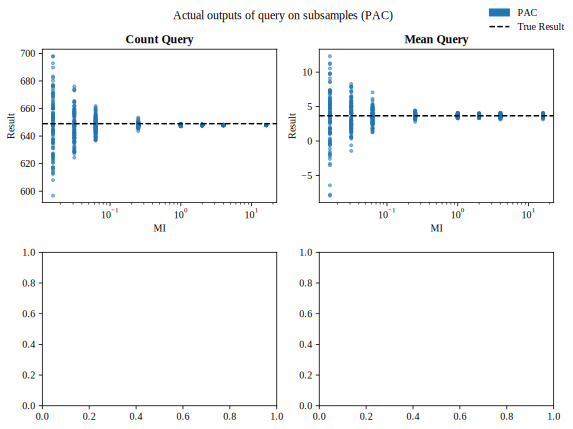

In [33]:
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = ['count',  'mean']
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'
    if query == 'count':
        ax.scatter(df['mi'], df[query]*2, label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    else:
        ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
        

    #d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    #ax.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [46]:
# max df[2]
df.sort_values(by='sum', ascending=False)[df['mi']==1]

/var/folders/xy/7x33379123vd25mldyhv3q7m0000gn/T/ipykernel_52781/341310330.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df.sort_values(by='sum', ascending=False)[df['mi']==1]


,mi,count,sum,mean,var
154,1.0,345.039795,5198.635985,3.990266,-143.926732
171,1.0,330.664840,4677.708797,-2.323854,24.720621
179,1.0,336.799159,3860.105859,1.605498,61.431743
193,1.0,347.136780,3858.951817,9.887454,33.486452
192,1.0,325.692849,3801.859925,2.848082,52.174333
170,1.0,302.674015,3797.175773,-3.561850,68.450573
165,1.0,301.709941,3500.632390,6.030848,-108.211759
180,1.0,299.508402,3500.567522,0.455372,7.498653
157,1.0,345.728767,3499.555534,2.378867,160.517110
196,1.0,316.907754,3251.425384,-1.922119,69.245014


In [40]:
true_result

array([ 649.        , 2375.        ,    3.65947612,   21.53664232])

In [37]:
saved_pac_variables_df 

,out_np_0,fin_var,sqrt_total_var,pac_noise,pac_noises_to_add,pac_release
0,"[324.0, 1243.0, 3.8364197530864197, 23.4127871...","[0.25, 3678.70703125, 0.0349122657236967, 6.09...",63.807867,"[0.9969979150653837, 120.94052428749744, 0.372...","[-1.251179065036171, 48.48270205548689, -0.272...","[322.7488209349638, 1291.482702055487, 3.56359..."
1,"[324.0, 1188.0, 3.6666666666666665, 22.2662538...","[0.25, 3619.70703125, 0.034257270615169214, 5....",63.262561,"[0.9884775164319705, 118.94152481934539, 0.365...","[-0.04969984104056907, 161.78830358600607, 0.0...","[323.9503001589594, 1349.7883035860061, 3.7132..."
2,"[324.0, 1222.0, 3.771604938271605, 22.08389710...","[0.25, 3245.01171875, 0.030728963267671952, 5....",59.891365,"[0.9358025819154189, 106.61599626878855, 0.328...","[0.573571522458508, 77.89100221849479, 0.12034...","[324.5735715224585, 1299.8910022184948, 3.8919..."
3,"[324.0, 1198.0, 3.697530864197531, 19.80296602...","[0.25, 3187.015625, 0.0303488331269928, 5.2324...",59.415324,"[0.9283644412678782, 104.81913936298689, 0.323...","[1.077962122737708, -104.0080404925753, 0.2137...","[325.0779621227377, 1093.9919595074248, 3.9113..."
4,"[324.0, 1196.0, 3.691358024691358, 24.32549784...","[0.25, 3502.29296875, 0.03317521030053548, 5.6...",62.244490,"[0.9725701573066674, 115.11374184725669, 0.354...","[-2.4271731211023377, 14.803744910295816, 0.07...","[321.5728268788977, 1210.8037449102958, 3.7691..."
...,...,...,...,...,...,...
395,"[324.0, 1203.0, 3.712962962962963, 18.26100791...","[0.25, 3392.53125, 0.03210507208977054, 5.2110...",61.207382,"[979.3181167077661, 114081.62869747773, 350.94...","[777.9132949331771, -19995.34900760166, -162.9...","[1101.913294933177, -18792.34900760166, -159.2..."
396,"[324.0, 1099.0, 3.3919753086419755, 19.9356629...","[0.25, 3631.578125, 0.03449537601526036, 5.691...",63.333986,"[1013.3437724481928, 122133.41319206536, 376.4...","[1255.8930425716705, -7077.519554390143, 60.83...","[1579.8930425716705, -5978.519554390143, 64.23..."
397,"[324.0, 1207.0, 3.7253086419753085, 21.4753946...","[0.25, 3183.34375, 0.030113725306982645, 5.195...",59.374024,"[949.9843914333164, 107198.38299204838, 329.70...","[-458.1525337383059, 10752.443904901816, 74.09...","[-134.15253373830592, 11959.443904901816, 77.8..."
398,"[324.0, 1117.0, 3.447530864197531, 18.55760998...","[0.25, 3860.96484375, 0.03647186319802245, 5.9...",65.276287,"[1044.4205905918311, 129793.61977892142, 398.9...","[-56.682021852460934, 21187.38960948393, -163....","[267.31797814753907, 22304.38960948393, -160.2..."


In [ ]:
### How much error are we adding? (PAC)
### Plotting the actual experiment outputs used (PAC)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = ['count', 'sum', 'mean', 'var']
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'pac'

    saved_pac_variables_df['pac_noise']

    ax.scatter(df['mi'], df[query], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    #for mi in MI_OPTIONS:
        #d = df.iloc[:, [0, i]].where(df['mi'] == mi).dropna()
        #ax.scatter(d.iloc[:, 0], d.iloc[:, 1], label=query, marker='.', alpha=0.5, color=PAC_COLOR)
        #ax.boxplot(d.iloc[:, 1], positions=[mi], widths=0.1, showfliers=False)
        

    #d = errors_df.loc[TYPE].loc[:, f'absolute error {query} var']
    #ax.plot(d.index, d, label=query, marker='.', color=PAC_COLOR)
    ax.set_xscale('log')
    #ax.set_yscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('MI')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=PAC_COLOR, edgecolor=PAC_COLOR, label='PAC'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

fig.suptitle("Actual outputs of query on subsamples (PAC)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_pac.jpg", bbox_inches='tight')
plt.show()

In [30]:
df[df['mi'] == 1]

,mi,count,sum,mean,var
150,1.0,321.318657,2345.601800,8.634098,-77.395256
151,1.0,314.295251,2524.972391,5.486064,90.885301
152,1.0,294.829151,849.456731,4.521235,158.273002
153,1.0,349.261174,598.901410,2.493268,68.324316
154,1.0,345.039795,5198.635985,3.990266,-143.926732
155,1.0,318.576492,1795.450702,6.338124,134.341825
156,1.0,326.451005,-65.150767,0.644788,-46.432190
157,1.0,345.728767,3499.555534,2.378867,160.517110
158,1.0,265.648345,1638.952790,1.955163,18.253940
159,1.0,326.612292,3165.773144,0.704107,43.646640


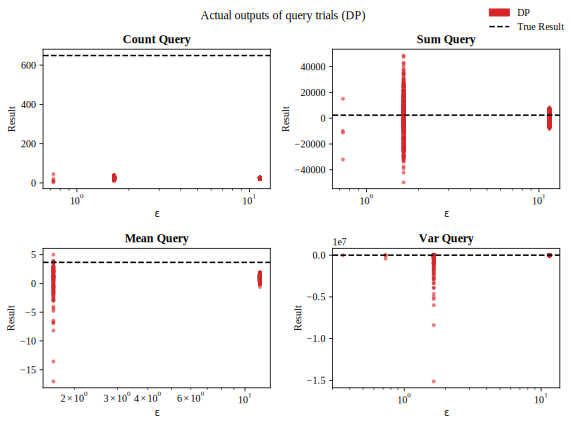

In [31]:
### Plotting the actual experiment outputs used (DP)
# Plotting each query type with their error metrics
fig, axs = plt.subplots(2, 2, figsize=(8, 6))
queries = ['count', 'sum', 'mean', 'var']
# Loop through each query to create the subplots
for i, query in enumerate(queries):
    # go from top left, to top right, to bottom left, to bottom right
    row = i//2
    col = i%2
    ax = axs[row][col]

    # Plotting Sample Std of Absolute Scaled Error
    TYPE = 'dp'

    ax.scatter(dp_results_df['eps'], dp_results_df[query], label=query, marker='.', alpha=0.5, color=DP_COLOR)
    ax.axhline(y=true_result[i], color='black', linestyle='--', label='True Result')

    ax.set_xscale('log')
    ax.set_title(f'{query.capitalize()} Query')
    ax.set_xlabel('$\epsilon$')
    ax.set_ylabel('Result')

fig.legend(handles=[
    Patch(facecolor=DP_COLOR, edgecolor=DP_COLOR, label='DP'),
    Line2D([0], [0], color='black', linestyle='--', label='True Result')
], loc='upper right', frameon=False)

fig.suptitle("Actual outputs of query trials (DP)")
plt.tight_layout()
fig.savefig(f"{OUTPUT_DIR}/actual_outputs_dp.jpg", bbox_inches='tight')
plt.show()

In [32]:
# dp_ps_to_epsilon(calc_posterior(mi)) -> epsilon
x = np.logspace(-8, 4, base=2, num=80)
y = [dp_ps_to_epsilon(calc_posterior(i)) for i in x] # eps
ps = [calc_posterior(i) for i in x] # posterior success

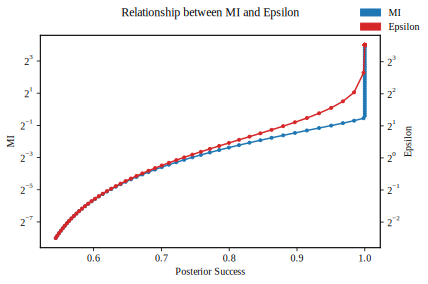

In [33]:
# Plot the relationship between MI and epsilon
fig, ax = plt.subplots(figsize=(6, 4))

ax.plot(ps, x, label='MI', color=PAC_COLOR, marker='.')
ax2 = ax.twinx()
ax2.plot(ps, y, label='Epsilon', color=DP_COLOR, marker='.')

ax.set_xlabel('Posterior Success')
ax.set_ylabel('MI')
ax2.set_ylabel('Epsilon')

ax.set_yscale('log', base=2)
ax2.set_yscale('log', base=2)

fig.suptitle("Relationship between MI and Epsilon")
fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False, labels=['MI', 'Epsilon'])

plt.tight_layout()
plt.show()


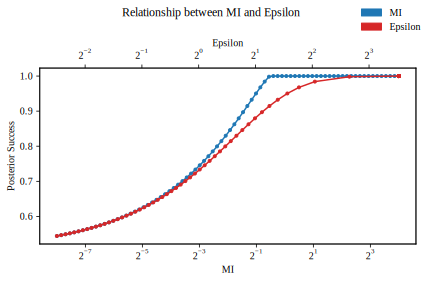

In [34]:
fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(x, ps, color=PAC_COLOR, marker='.')
ax2 = ax.twiny()
ax2.plot(y, ps, color=DP_COLOR, marker='.')
ax.set_xlabel('MI')
ax.set_ylabel('Posterior Success')
ax2.set_xlabel('Epsilon')
ax.set_xscale('log', base=2)
ax2.set_xscale('log', base=2)
fig.suptitle("Relationship between MI and Epsilon")
fig.legend(handles=pac_dp_legend_handles, loc='upper right', frameon=False, labels=['MI', 'Epsilon'])
plt.tight_layout()
plt.show()